In [1]:
import pandas
import numpy as np
import matplotlib.pyplot as plt
% matplotlib inline

In [2]:
data = pandas.read_csv('MEU-Mobile.csv')

cols_Hold = ['Hold .', 'Hold t', 'Hold i', 'Hold e', 'Hold Shift', 'Hold 5', 'Hold Shift.1', 'Hold Caps', 'Hold r', 'Hold o', 'Hold a', 'Hold n', 'Hold l', 'Hold Enter']
data['Std H'] = np.std(data[cols_Hold], axis=1)
cols_Pressure = ['Pressure .', 'Pressure t', 'Pressure i', 'Pressure e', 'Pressure Shift', 'Pressure 5', 'Pressure Shift.1', 'Pressure Caps', 'Pressure r', 'Pressure o', 'Pressure a', 'Pressure n', 'Pressure l', 'Pressure Enter']
data['Std P'] = np.std(data[cols_Pressure], axis=1)
cols_Area = ['Size .', 'Size t', 'Size i', 'Size e', 'Size Shift', 'Size 5', 'Size Shift.1', 'Size Caps', 'Size r', 'Size o', 'Size a', 'Size n', 'Size l', 'Size Enter']
data['Std A'] = np.std(data[cols_Area], axis=1)

In [13]:
cols_to_drop = list(data)[28:28+13]

In [14]:
X1 = data.drop(cols_to_drop, axis=1, inplace=False)

## Feature selection
# PCA

In [3]:
import matplotlib.pyplot as plt
% matplotlib inline

In [5]:
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.preprocessing import StandardScaler
pca = PCA(n_components=2)

X = X1.drop('Subject', axis=1, inplace=False)
Y = X1['Subject'].values
#X = data.drop('Subject', axis=1, inplace=False)
X = X.values

scaler = StandardScaler()
X_norm = scaler.fit_transform(X)
X_reduced = pca.fit_transform(X_norm)

print((pca.explained_variance_ratio_[0], pca.explained_variance_ratio_[1], pca.explained_variance_ratio_[0] + pca.explained_variance_ratio_[1]))

NameError: name 'X1' is not defined

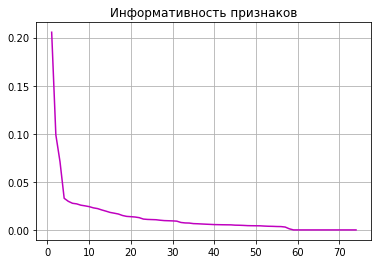

[]


In [59]:
x = range(1, 75)
plt.title('Информативность признаков')
plt.plot(x, pca.explained_variance_ratio_, color='m')
#plt.legend()
plt.grid()
plt.show()
print(plot_out[:-17])
#17 last are no info   #TODO grid

Projecting 61-dimensional data to 2D


Text(0.5,1,'Проекция данных о разных пользователях на плоскость')

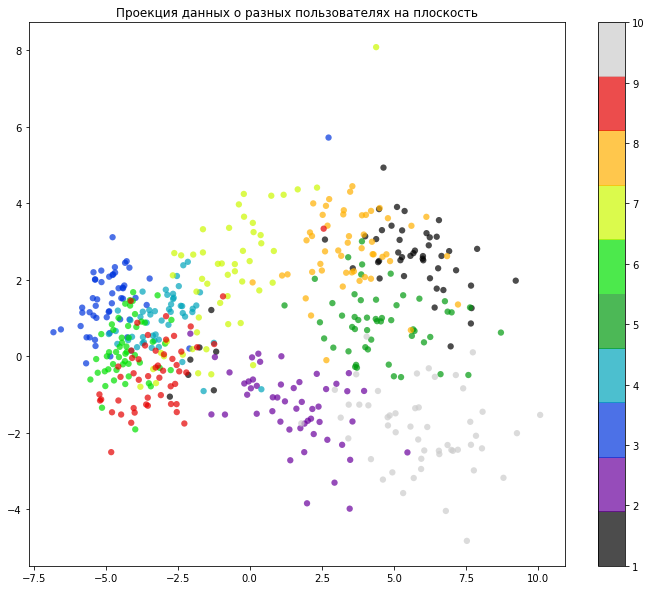

In [141]:
print('Projecting %d-dimensional data to 2D' % X.shape[1])

plt.figure(figsize=(12,10))
plt.scatter(X_reduced[:51 * 10, 0], X_reduced[:51 * 10, 1], c=Y[:51 * 10], 
            edgecolor='none', alpha=0.7, s=40,
            cmap=plt.cm.get_cmap('nipy_spectral', 10))
plt.colorbar()
plt.title('Проекция данных о разных пользователях на плоскость')

Text(0.5,1,'MNIST. t-SNE projection')

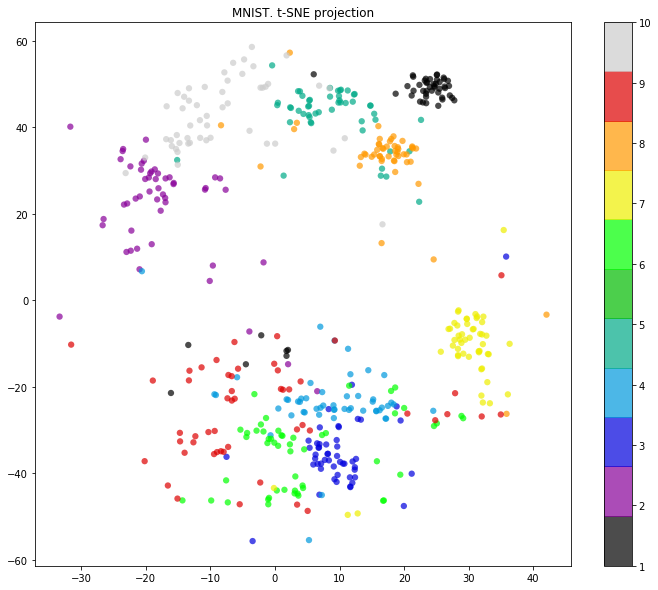

In [6]:
from sklearn.manifold import TSNE
tsne = TSNE(random_state=17)

X_tsne = tsne.fit_transform(X_reduced)

plt.figure(figsize=(12,10))
plt.scatter(X_tsne[:510, 0], X_tsne[:510, 1], c=Y[:510], 
            edgecolor='none', alpha=0.7, s=40,
            cmap=plt.cm.get_cmap('nipy_spectral', 11))
plt.colorbar()
plt.title('MNIST. t-SNE projection')

# Template
## Distance-based

In [14]:
from sklearn.preprocessing import StandardScaler

X = data.drop('Subject', axis=1, inplace=False)
X = X.values

from scipy.spatial.distance import cdist
metrics = ['euclidean', 'cityblock']
num_users = 56
good_train_size = 40
num_shuf = 5
plot_out = []
plot_test = []
x = range(92, 100, 1)
for metr in metrics:
    print()
    print('Metric:', metr)
    print()
    for thres in x:
        print('Threshold =', thres, '%') 
        thres_array = []
        errors_out = []                
        errors_test = []
        for user in range(num_users):
            X_good = X[user * 51:(user + 1) * 51]
            for shuf in range(num_shuf):
                scaler = StandardScaler()
                np.random.shuffle(X_good)

                X_train = scaler.fit_transform(X_good[:good_train_size])
                X_test = scaler.transform(X_good[good_train_size:])
                X_out = scaler.transform(np.concatenate((X[:user * 51], X[(user + 1) * 51:]), axis=0))

                np.random.shuffle(X_out)

                template = np.mean(X_train, axis=0).reshape((1,-1))
                dist_train = []
                for i in range(X_train.shape[0]):
                    dist_train.append(cdist(template, X_train[i, :].reshape((1, -1)), metr))
                dist_test = []
                for i in range(X_test.shape[0]):
                    dist_test.append(cdist(template, X_test[i, :].reshape((1, -1)), metr))

                dist_out = []
                for i in range(X_out.shape[0]):
                    dist_out.append(cdist(template, X_out[i, :].reshape((1, -1)), metr))

                threshold = np.percentile(dist_train, thres)
                thres_array.append(threshold)

                err_test = 0
                for dist in dist_test:
                    if dist > threshold:
                        err_test += 1
                errors_test.append(err_test)

                err_out = 0
                for dist in dist_out:
                    if dist <= threshold:
                        err_out += 1
                errors_out.append(err_out)

        print("OUT-mean", np.mean(errors_out) / X_out.shape[0])
        plot_out.append(np.mean(errors_out) / X_out.shape[0] * 100)
        print("OUT-std", np.std(errors_out) / X_out.shape[0])

        print("TEST-mean", np.mean(errors_test) / X_test.shape[0])
        plot_test.append(np.mean(errors_test) / X_test.shape[0] * 100)
        print("TEST-std", np.std(errors_test) / X_test.shape[0])

        print("threshold", np.mean(thres_array))
        print()

plt.title('Сравнение результатов с использованием различных метрик')
plt.plot(x, plot_out[:len(x)], color='m', label='Евклидова - FAR')
plt.plot(x, plot_out[len(x):2 * len(x)], color='green', label='Манхэттенская - FAR')
plt.plot(x, plot_test[:len(x)], 'm--', label='Евклидова - FRR')
plt.plot(x, plot_test[len(x):2 * len(x)], 'g--', label='Манхэттенская - FRR')
plt.xlabel('Перцентиль')
plt.ylabel('Процент ошибок')
plt.grid()
plt.legend()
plt.show()


Metric: euclidean

Threshold = 92 %
OUT-mean 0.08909854851031322
OUT-std 0.09308072985700908
TEST-mean 0.22564935064935066
TEST-std 0.1301518859205246
threshold 11.048341058981304

Threshold = 93 %


KeyboardInterrupt: 

In [20]:
from sklearn.preprocessing import StandardScaler

X = data.drop('Subject', axis=1, inplace=False)
X = X.values

from scipy.spatial.distance import mahalanobis
num_users = 56
good_train_size = 40
num_shuf = 5
plot_out = []
plot_test = []
x = range(75, 85)
print()
print('Metric:mahalanobis')
print()
for thres in x:
    print('Threshold =', thres, '%') 
    thres_array = []
    errors_out = []                
    errors_test = []
    for user in range(num_users):
        for shuf in range(num_shuf):
            X_good = X[user * 51:(user + 1) * 51]
            scaler = StandardScaler()                    
            pca = PCA(n_components=40)
            np.random.shuffle(X_good)

            X_train_old = scaler.fit_transform(X_good[:good_train_size])
            X_test_old = scaler.transform(X_good[good_train_size:])
            X_out_old = scaler.transform(np.concatenate((X[:user * 51], X[(user + 1) * 51:]), axis=0))
            np.random.shuffle(X_out_old)
                    
            X_train = pca.fit_transform(X_train_old)
            X_test = pca.transform(X_test_old)
            X_out = pca.transform(X_out_old)

            template = np.mean(X_train, axis=0)
                
            VI = np.cov(X_train)
                
            dist_train = []
            for i in range(X_train.shape[0]):
                dist_train.append(mahalanobis(template, X_train[i, :], VI))
                    
            dist_test = []
            for i in range(X_test.shape[0]):
                dist_test.append(mahalanobis(template, X_test[i, :], VI))

            dist_out = []
            for i in range(X_out.shape[0]):
                dist_out.append(mahalanobis(template, X_out[i, :], VI))

            threshold = np.percentile(dist_train, thres)
            thres_array.append(threshold)

            err_test = 0
            for dist in dist_test:
                if dist > threshold:
                    err_test += 1
            errors_test.append(err_test)

            err_out = 0
            for dist in dist_out:
                if dist <= threshold:
                    err_out += 1
            errors_out.append(err_out)

    print("OUT-mean", np.mean(errors_out) / X_out.shape[0])
    plot_out.append(np.mean(errors_out) / X_out.shape[0] * 100)
    print("OUT-std", np.std(errors_out) / X_out.shape[0])

    print("TEST-mean", np.mean(errors_test) / X_test.shape[0])
    plot_test.append(np.mean(errors_test) / X_test.shape[0] * 100)
    print("TEST-std", np.std(errors_test) / X_test.shape[0])

    print("threshold", np.mean(thres_array))
    print()

plt.title('Сравнение результатов с использованием различных метрик')
plt.plot(x, plot_out[:len(x)], color='r', label='Махаланобис - FAR')
plt.plot(x, plot_test[:len(x)], 'b', label='Махаланобис - FRR')
plt.xlabel('Перцентиль')
plt.ylabel('Процент ошибок')
plt.grid()
plt.legend()
plt.show()


Metric:mahalanobis

Threshold = 75 %
OUT-mean 0.08773491214667685
OUT-std 0.07814705973743383
TEST-mean 0.2532467532467532
TEST-std 0.14344624697645794
threshold 12.750112597697285

Threshold = 76 %


KeyboardInterrupt: 

ValueError: x and y must have same first dimension, but have shapes (5,) and (1,)

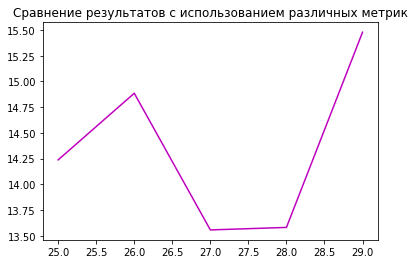

In [67]:
plot_out = [x * 100 for x in plot_out]
plot_test = [x * 100 for x in plot_test]

plt.title('Сравнение результатов с использованием различных метрик')
plt.plot(x, plot_out[:len(x)], color='m', label='Евклидова - FAR')
plt.plot(x, plot_out[len(x):2 * len(x)], color='green', label='Манхэттенская - FAR')
plt.plot(x, plot_test[:len(x)], 'm--', label='Евклидова - FRR')
plt.plot(x, plot_test[len(x):2 * len(x)], 'g--', label='Манхэттенская - FRR')
plt.legend()
plt.xlabel('Перцентиль')
plt.ylabel('Процент ошибок')
plt.grid()
plt.show()

## Размер обучающей выборки

------
10
OUT-mean 0.0419633307869
OUT-std 0.0540652864454
TEST-mean 0.248780487805
TEST-std 0.16321689633
------
11
OUT-mean 0.0439508530685
OUT-std 0.058999038703
TEST-mean 0.233125
TEST-std 0.143656219409
------
12
OUT-mean 0.0432238349885
OUT-std 0.0602654318921
TEST-mean 0.228937728938
TEST-std 0.146790044457
------
13
OUT-mean 0.0399121466769
OUT-std 0.0461858141889
TEST-mean 0.218515037594
TEST-std 0.140304628832
------
14
OUT-mean 0.0467914438503
OUT-std 0.063082706114
TEST-mean 0.201158301158
TEST-std 0.12359072756
------
15
OUT-mean 0.0412732365674
OUT-std 0.0519079317504
TEST-mean 0.204464285714
TEST-std 0.125204504858
------
16
OUT-mean 0.0428214922333
OUT-std 0.0536071996602
TEST-mean 0.196224489796
TEST-std 0.124541265707
------
17
OUT-mean 0.0443277310924
OUT-std 0.0523869804874
TEST-mean 0.187920168067
TEST-std 0.119141867249
------
18
OUT-mean 0.0458734402852
OUT-std 0.0544116147537
TEST-mean 0.192965367965
TEST-std 0.12281289721
------
19
OUT-mean 0.0427578304049
OUT-

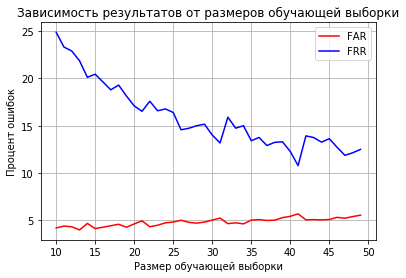

In [54]:
from sklearn.preprocessing import StandardScaler

X = data.drop('Subject', axis=1, inplace=False)
X = X.values

#good_train_size = 35
num_users = 56
num_shuf = 5
plot_out = []
plot_test = []
l = 0.9

x = range(10, 50, 1)
for good_train_size in x:
    thres_array = []
    errors_out = []
    errors_test = []
    for k in range(1):
        print("------")
        print(good_train_size)
        for user in range(num_users):
            for shuf in range(num_shuf):
                X_good = X[user * 51:(user + 1) * 51]
                scaler = StandardScaler()
                np.random.shuffle(X_good)

                X_train = scaler.fit_transform(X_good[:good_train_size])
                X_test = scaler.transform(X_good[good_train_size:])
                X_out = scaler.transform(np.concatenate((X[:user * 51], X[(user + 1) * 51:]), axis=0))

                np.random.shuffle(X_out)

                vals_train = []
                for i in range(X_train.shape[0]):
                    current = X_train[i, :]
                    n_err = current[current < -l].size + current[current > l].size
                    vals_train.append(n_err)

                vals_test = []
                for i in range(X_test.shape[0]):
                    current = X_test[i, :]
                    n_err = current[current < -l].size + current[current > l].size
                    vals_test.append(n_err)

                vals_out = []
                for i in range(X_out.shape[0]):
                    current = X_out[i, :]
                    n_err = current[current < -l].size + current[current > l].size
                    vals_out.append(n_err)

                threshold = np.percentile(vals_train, 90)
                #thres_array.append(threshold)
                #threshold = thres                                       

                err_test = 0
                for val in vals_test:
                    if val > threshold:
                        err_test += 1
                errors_test.append(err_test)

                err_out = 0
                for val in vals_out:
                    if val <= threshold:
                        err_out += 1
                errors_out.append(err_out)


        print("OUT-mean", np.mean(errors_out) / X_out.shape[0])
        plot_out.append(np.mean(errors_out) / X_out.shape[0] * 100)
        print("OUT-std", np.std(errors_out) / X_out.shape[0])
        
        print("TEST-mean", np.mean(errors_test) / X_test.shape[0])
        plot_test.append(np.mean(errors_test) / X_test.shape[0] * 100)
        print("TEST-std", np.std(errors_test) / X_test.shape[0])
        
        #print("threshold", np.mean(thres_array))
        
        
plt.title('Зависимость результатов от размеров обучающей выборки')
plt.plot(x, plot_out, color='red', label='FAR')
plt.plot(x, plot_test, color='blue', label='FRR')
plt.xlabel('Размер обучающей выборки')
plt.ylabel('Процент ошибок')
plt.grid()
plt.legend()
plt.show()

## Interval

In [54]:
from sklearn.preprocessing import StandardScaler

X = data.drop('Subject', axis=1, inplace=False)
X = X.values

good_train_size = 40
num_users = 56
num_shuf = 5
plot_out = []
plot_test = []

x = range(86, 100)
for thres in x:
    print()
    print('Threshold =', thres, '%')
    thres_array = []
    errors_out = []
    errors_test = []
    for l in [0.9]:
        for user in range(num_users):
            for shuf in range(num_shuf):
                X_good = X[user * 51:(user + 1) * 51]
                scaler = StandardScaler()
                np.random.shuffle(X_good)

                X_train = scaler.fit_transform(X_good[:good_train_size])
                X_test = scaler.transform(X_good[good_train_size:])
                X_out = scaler.transform(np.concatenate((X[:user * 51], X[(user + 1) * 51:]), axis=0))

                np.random.shuffle(X_out)

                vals_train = []
                for i in range(X_train.shape[0]):
                    current = X_train[i, :]
                    n_err = current[current < -l].size + current[current > l].size
                    vals_train.append(n_err)

                vals_test = []
                for i in range(X_test.shape[0]):
                    current = X_test[i, :]
                    n_err = current[current < -l].size + current[current > l].size
                    vals_test.append(n_err)

                vals_out = []
                for i in range(X_out.shape[0]):
                    current = X_out[i, :]
                    n_err = current[current < -l].size + current[current > l].size
                    vals_out.append(n_err)

                threshold = np.percentile(vals_train, thres)
                thres_array.append(threshold)

                err_test = 0
                for val in vals_test:
                    if val > threshold:
                        err_test += 1
                errors_test.append(err_test)

                err_out = 0
                for val in vals_out:
                    if val <= threshold:
                        err_out += 1
                errors_out.append(err_out)


        print("OUT-mean", np.mean(errors_out) / X_out.shape[0])
        plot_out.append(np.mean(errors_out) / X_out.shape[0] * 100)
        print("OUT-std", np.std(errors_out) / X_out.shape[0])
        
        print("TEST-mean", np.mean(errors_test) / X_test.shape[0])
        plot_test.append(np.mean(errors_test) / X_test.shape[0] * 100)
        print("TEST-std", np.std(errors_test) / X_test.shape[0])
        
        print("threshold", np.mean(thres_array))
        
        
plt.title('Подбор оптимального значения порога (перцентиля)')
plt.plot(x, plot_out, color='red', label='FAR')
plt.plot(x, plot_test, color='blue', label='FRR')
plt.legend()
plt.xlabel('Перцентиль')
plt.ylabel('Процент ошибок')
plt.grid()
plt.show()


Threshold = 86 %
OUT-mean 0.037793481028775146
OUT-std 0.04367766274077525
TEST-mean 0.17207792207792208
TEST-std 0.13294255293740445
threshold 25.95228571428571

Threshold = 87 %
OUT-mean 0.03722561751973517
OUT-std 0.041725919153595074
TEST-mean 0.18246753246753247
TEST-std 0.1255431780695027
threshold 26.13457142857143

Threshold = 88 %
OUT-mean 0.04592309651133181
OUT-std 0.05155930527937665
TEST-mean 0.1457792207792208
TEST-std 0.12329072539514119
threshold 26.57742857142857

Threshold = 89 %
OUT-mean 0.04631652661064426
OUT-std 0.0500635697193965
TEST-mean 0.14448051948051946
TEST-std 0.109437741022285
threshold 26.74757142857143

Threshold = 90 %
OUT-mean 0.052452253628724216
OUT-std 0.056544990489434795
TEST-mean 0.14123376623376624
TEST-std 0.10989912039618709
threshold 27.0575

Threshold = 91 %
OUT-mean 0.051917494270435446
OUT-std 0.05381300007713889
TEST-mean 0.13084415584415585
TEST-std 0.11067143170323458
threshold 27.305178571428574

Threshold = 92 %
OUT-mean 0.05712121

KeyboardInterrupt: 

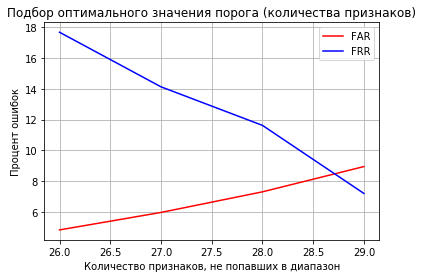

In [61]:
plt.title('Подбор оптимального значения порога (количества признаков)')
plt.plot(x[1:], plot_out[1:], color='red', label='FAR')
plt.plot(x[1:], plot_test[1:], color='blue', label='FRR')
plt.legend()
plt.xlabel('Количество признаков, не попавших в диапазон')
plt.ylabel('Процент ошибок')
plt.grid()
plt.show()

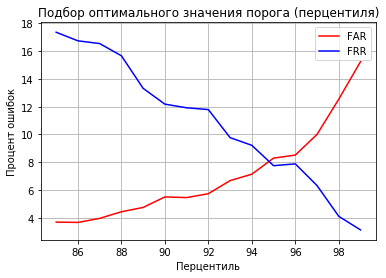

In [53]:
plt.title('Подбор оптимального значения порога (перцентиля)')
plt.plot(x[20:], plot_out[20:], color='red', label='FAR')
plt.plot(x[20:], plot_test[20:], color='blue', label='FRR')
plt.legend()
plt.xlabel('Перцентиль')
plt.ylabel('Процент ошибок')
plt.grid()
plt.show()

# Isolation Forest

In [56]:

X = data.drop('Subject', axis=1, inplace=False)
X = X.values

from sklearn.ensemble import IsolationForest

num_users = 56             
train_size = 40
num_shuf = 5
plot_out = []
plot_test = []
x = range(5, 16, 1)

for thres in x:
    print()
    print('Threshold =', thres, '%')
    errors_test = []
    errors_out = []
    for max_feat in [0.55]:
        for user in range(num_users):         
            X_good = X[user * 51:(user + 1) * 51]
            X_out = np.concatenate((X[:user * 51], X[(user + 1) * 51:]), axis=0)
            for shuf in range(num_shuf):
                np.random.shuffle(X_good)
                np.random.shuffle(X_out)
                X_train = X_good[:train_size]
                X_test = X_good[train_size:]
                    
                clf = IsolationForest(n_estimators=100, max_features=max_feat, max_samples=0.9,
                                     random_state=42)
                clf.fit(X_train)
                
                decision_func_train = clf.decision_function(X_train)    
                threshold = np.percentile(decision_func_train, thres) 
                decision_func_test = clf.decision_function(X_test)
                decision_func_out = clf.decision_function(X_out)
                    
                err_test = 0
                for dec in decision_func_test:
                    if dec < threshold:
                        err_test += 1
                errors_test.append(err_test)
                            
                err_out = 0
                for dec in decision_func_out:
                    if dec >= threshold:
                        err_out += 1
                errors_out.append(err_out)              
  
        print("OUT-mean", np.mean(errors_out) / X_out.shape[0])
        plot_out.append(np.mean(errors_out) / X_out.shape[0] * 100)
        print("OUT-std", np.std(errors_out) / X_out.shape[0])
        
        print("TEST-mean", np.mean(errors_test) / X_test.shape[0])
        plot_test.append(np.mean(errors_test) / X_test.shape[0] * 100)
        print("TEST-std", np.std(errors_test) / X_test.shape[0])

plt.title('Зависимость результатов от max_features')
plt.ylabel('Доля ошибок')
plt.xlabel('max_features')
plt.plot(x, plot_out[-len(x):], color='red', label='FAR')
plt.plot(x, plot_test[-len(x):], color='b', label='FRR')
plt.legend()
plt.grid()
plt.show()


Threshold = 5 %
OUT-mean 0.19268143621084796
OUT-std 0.1610625247414059
TEST-mean 0.06363636363636363
TEST-std 0.08324867797681737

Threshold = 6 %


KeyboardInterrupt: 

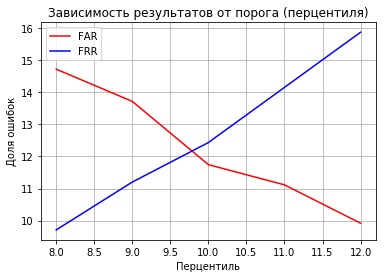

In [39]:
plt.title('Зависимость результатов от порога (перцентиля)')
plt.ylabel('Доля ошибок')
plt.xlabel('Перцентиль')
plt.plot(x[3:8], plot_out[-len(x) + 3:-len(x) + 8], color='red', label='FAR')
plt.plot(x[3:8], plot_test[-len(x) + 3:-len(x) + 8], color='b', label='FRR')
plt.legend()
plt.grid()
plt.show()

# LOF


Metric: cityblock

Number of neighbours: 4
OUT-mean 0.08311306340718105
OUT-std 0.08941096997203256
TEST-mean 0.15941558441558443
TEST-std 0.11677439026728927

Number of neighbours: 5
OUT-mean 0.09670868347338936
OUT-std 0.09668304997747738
TEST-mean 0.13863636363636364
TEST-std 0.1162460089322642

Number of neighbours: 6
OUT-mean 0.10237331296154825
OUT-std 0.10505395016750364
TEST-mean 0.13441558441558443
TEST-std 0.11394392515891613

Number of neighbours: 7
OUT-mean 0.10480646804176215
OUT-std 0.10657409920510479
TEST-mean 0.1288961038961039
TEST-std 0.11082372623454187

Number of neighbours: 8
OUT-mean 0.10585561497326204
OUT-std 0.10106516093118166
TEST-mean 0.12435064935064935
TEST-std 0.10092703629564527

Number of neighbours: 9
OUT-mean 0.10302266361089892
OUT-std 0.09357773124486565
TEST-mean 0.11331168831168831
TEST-std 0.11186890790222712

Number of neighbours: 10
OUT-mean 0.10466131907308378
OUT-std 0.09460553305129842
TEST-mean 0.10844155844155844
TEST-std 0.0971229752555

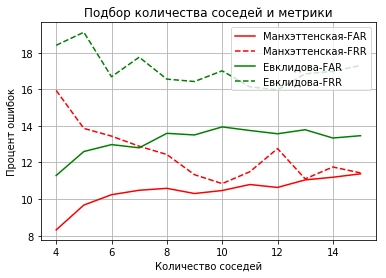

In [110]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD

#X = data.drop('Subject', axis=1, inplace=False)
X = X1.drop('Subject', axis=1, inplace=False)
X = X.values

from sklearn.neighbors import LocalOutlierFactor

good_train_size = 40
num_users = 56
num_shuf = 5
plot_out = []
plot_test = []
x = range(4, 16)

for metr in ['cityblock', 'euclidean']:
    print()
    print('Metric:', metr)
    for neib in x:
        print()
        print('Number of neighbours:', neib)
        for thres in [2]:
            errors_out = []
            errors_test = []
            for user in range(num_users):
                for shuf in range(num_shuf):
                    X_good = X[user * 51:(user + 1) * 51]
                    scaler = StandardScaler()
                    np.random.shuffle(X_good)

                    X_train = scaler.fit_transform(X_good[:good_train_size])
                    X_test = scaler.transform(X_good[good_train_size:])
                    X_out = scaler.transform(np.concatenate((X[:user * 51], X[(user + 1) * 51:]), axis=0))

                    np.random.shuffle(X_out)

                    clf = LocalOutlierFactor(n_neighbors=neib, metric=metr)
                    clf.fit(X_train)
                    y_pred_test = clf._decision_function(X_test)
                    y_pred_out = clf._decision_function(X_out)

                    threshold = np.percentile(clf._decision_function(X_train), thres)

                    err_test = y_pred_test[y_pred_test < threshold].size
                    errors_test.append(err_test)

                    err_out = y_pred_out[y_pred_out >= threshold].size
                    errors_out.append(err_out)

            print("OUT-mean", np.mean(errors_out) / X_out.shape[0])
            plot_out.append(np.mean(errors_out) / X_out.shape[0] * 100)
            print("OUT-std", np.std(errors_out) / X_out.shape[0])

            print("TEST-mean", np.mean(errors_test) / X_test.shape[0])
            plot_test.append(np.mean(errors_test) / X_test.shape[0] * 100)
            print("TEST-std", np.std(errors_test) / X_test.shape[0])

plt.title('Подбор количества соседей и метрики')
plt.plot(x, plot_out[:len(x)], color='r', label='Манхэттенская-FAR')
plt.plot(x, plot_test[:len(x)], 'r--', label='Манхэттенская-FRR')
plt.plot(x, plot_out[len(x):2 * len(x)], color='g', label='Евклидова-FAR')
plt.plot(x, plot_test[len(x):2 * len(x)], 'g--', label='Евклидова-FRR')
plt.legend()
plt.xlabel('Количество соседей')
plt.ylabel('Процент ошибок')
plt.grid()
plt.show()

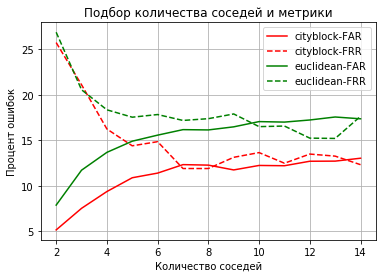

In [27]:
plt.title('Подбор количества соседей и метрики')
plt.plot(x[1:], plot_out[1:len(x)], color='r', label='Манхэттенская-FAR')
plt.plot(x[1:], plot_test[1:len(x)], 'r--', label='Манхэттенская-FRR')
plt.plot(x[1:], plot_out[len(x) + 1:2 * len(x)], color='g', label='Евклидова-FAR')
plt.plot(x[1:], plot_test[len(x) + 1:2 * len(x)], 'g--', label='Евклидова-FRR')

plt.legend()
plt.xlabel('Количество соседей')
plt.ylabel('Процент ошибок')
plt.grid()
plt.show()

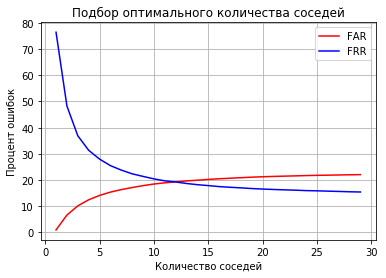

In [28]:
plt.title('Подбор оптимального количества соседей')
plt.plot(x, plot_out, color='red', label='FAR')
plt.plot(x, plot_test, color='blue', label='FRR')
plt.legend()
plt.xlabel('Количество соседей')
plt.ylabel('Процент ошибок')
plt.grid()
plt.show()

# One-class SVM


Gamma: 0.011
OUT-mean 0.2191405653170359
OUT-std 0.17011395055000084
TEST-mean 0.10422077922077921
TEST-std 0.10350932470178355

Gamma: 0.012
OUT-mean 0.2039101094983448
OUT-std 0.1628414181370399
TEST-mean 0.10974025974025974
TEST-std 0.10562482254244321

Gamma: 0.013
OUT-mean 0.18730837789661317
OUT-std 0.15547735502382787
TEST-mean 0.1253246753246753
TEST-std 0.11523184224288507

Gamma: 0.014
OUT-mean 0.1681168831168831
OUT-std 0.14056988284690097
TEST-mean 0.12564935064935065
TEST-std 0.11055707313100772

Gamma: 0.015
OUT-mean 0.1449134199134199
OUT-std 0.12723071407189632
TEST-mean 0.14837662337662338
TEST-std 0.11280353441098998

Gamma: 0.016
OUT-mean 0.1245212630506748
OUT-std 0.10879043318111568
TEST-mean 0.16753246753246753
TEST-std 0.12799951509437582
30


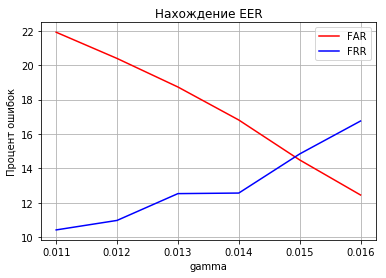

In [135]:
from sklearn.svm import OneClassSVM
from sklearn.preprocessing import StandardScaler

X = data.drop('Subject', axis=1, inplace=False)
X = X.values

from sklearn.svm import OneClassSVM

good_train_size = 40
num_users = 56
num_shuf = 5
plot_out = []
plot_test = []

x = np.arange(0.011, 0.016, 0.001)
for metr in ['cityblock']:
    for gam in x:
        print()
        print('Gamma:', round(gam, 4))
        for thres in [1]:
            errors_out = []
            errors_test = []
            for user in range(num_users):
                for shuf in range(num_shuf):
                    X_good = X[user * 51:(user + 1) * 51]
                    scaler = StandardScaler()                    
                    pca = PCA(n_components=40)
                    np.random.shuffle(X_good)

                    X_train_old = scaler.fit_transform(X_good[:good_train_size])
                    X_test_old = scaler.transform(X_good[good_train_size:])
                    X_out_old = scaler.transform(np.concatenate((X[:user * 51], X[(user + 1) * 51:]), axis=0))
                    np.random.shuffle(X_out_old)
                    
                    X_train = pca.fit_transform(X_train_old)
                    X_test = pca.transform(X_test_old)
                    X_out = pca.transform(X_out_old)

                    clf = OneClassSVM(kernel='rbf', nu=0.5, gamma=gam)
                    clf.fit(X_train)
                    
                    y_pred_test = clf._decision_function(X_test)
                    y_pred_out = clf._decision_function(X_out)
                    threshold = np.percentile(clf._decision_function(X_train), thres)

                    err_test = y_pred_test[y_pred_test < threshold].size
                    errors_test.append(err_test)

                    err_out = y_pred_out[y_pred_out >= threshold].size
                    errors_out.append(err_out)

            print("OUT-mean", np.mean(errors_out) / X_out.shape[0])
            plot_out.append(np.mean(errors_out) / X_out.shape[0] * 100)
            print("OUT-std", np.std(errors_out) / X_out.shape[0])

            print("TEST-mean", np.mean(errors_test) / X_test.shape[0])
            plot_test.append(np.mean(errors_test) / X_test.shape[0] * 100)
            print("TEST-std", np.std(errors_test) / X_test.shape[0])
            
print(pca.n_components_)

plt.title('Нахождение EER')
plt.plot(x, plot_out, color='r', label='FAR')
plt.plot(x, plot_test, 'b', label='FRR')
plt.legend()
plt.xlabel('gamma')
plt.ylabel('Процент ошибок')
plt.grid()
plt.show()

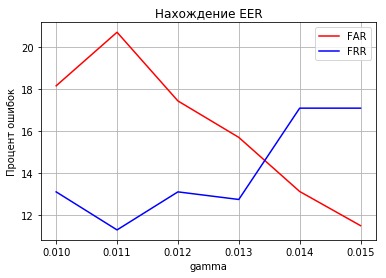

In [77]:
plt.title('Нахождение EER')
plt.plot(x[2:], plot_out[2:], color='r', label='FAR')
plt.plot(x[2:], plot_test[2:], 'b', label='FRR')
plt.legend()
plt.xlabel('gamma')
plt.ylabel('Процент ошибок')
plt.grid()
plt.show()

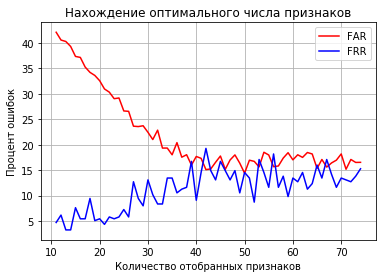

In [57]:
plt.title('Нахождение оптимального числа признаков')
plt.plot(x[10:], plot_out[10:], color='r', label='FAR')
plt.plot(x[10:], plot_test[10:], 'b', label='FRR')

plt.legend()
plt.xlabel('Количество отобранных признаков')
plt.ylabel('Процент ошибок')
plt.grid()
plt.show()